<a href="https://colab.research.google.com/github/amrit-thapa-2044/colab_miscellaneous/blob/main/Download_Daily_airT_ERA5_for_my_lon_lat_amrit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authenticate GEE and initiate library


In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()
#4/1AX4XfWhoutiHadZuP0Ip2eMb8hXF9kr3ynsDjtAwnHq8FO3hDYLNBAovDm8

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=A7L5GLirgDcQoUs9c2i7aVq8zo0XpE3bVEc6iMbyL_E&tc=RnSQFLkraJM9QTnW-Mehm8J9YJXS9lSBHEaI2PFT6YI&cc=8ml74k1EkC9NTRYKZv_HYd-v3UI5_jXfEEcb-qUmkyQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qjduMKSXMXfuoZ-86H9WhiqqhyXPioJWQ_ZtRTJmBYhFnoNJVa6nmw

Successfully saved authorization token.


# Define user variables

In [2]:
# Initial date of interest (inclusive).
i_date = '1982-01-01'

# Final date of interest (exclusive).
f_date = '2020-12-31'

# define variable of interest
my_variable='mean_2m_air_temperature' #

# Define the location of your interest as point geometry
my_lon = 81.69682
my_lat = 30.16007
my_point = ee.Geometry.Point(my_lon, my_lat)

scale = 30000  # scale in meters

# Load image collection

In [3]:
# Import the ERA5 image collection.
ERA5 = ee.ImageCollection('ECMWF/ERA5/DAILY')

# Filter image collection

In [4]:
# Selection of appropriate bands and dates.
ERA5_my_variable = ERA5.select(my_variable).filterDate(i_date, f_date)

# Extract value from image collection

In [5]:
# Get the data for the pixel intersecting the our point.
ERA5_my_variable_my_point = ERA5_my_variable.getRegion(my_point, scale).getInfo()

In [6]:
# Preview the result.
ERA5_my_variable_my_point[:5]

[['id', 'longitude', 'latitude', 'time', 'mean_2m_air_temperature'],
 ['19820101',
  81.79160661908243,
  30.048646253797994,
  378691200000,
  256.9055480957031],
 ['19820102',
  81.79160661908243,
  30.048646253797994,
  378777600000,
  256.2713317871094],
 ['19820103',
  81.79160661908243,
  30.048646253797994,
  378864000000,
  258.14593505859375],
 ['19820104',
  81.79160661908243,
  30.048646253797994,
  378950400000,
  259.2501220703125]]


# Convert result to dataframe

In [7]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'],unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [8]:
df_era5_my_point = ee_array_to_df(ERA5_my_variable_my_point,[my_variable])

# Convert Kelvin to Degree Celsius

In [9]:
def t_era5_to_celsius(t_era5):
    """Converts era5 Kelvin to degrees Celsius."""
    t_celsius =  t_era5 - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
df_era5_my_point[my_variable] = df_era5_my_point[my_variable].apply(t_era5_to_celsius)

In [10]:
df_era5_my_point.head()

,time,datetime,mean_2m_air_temperature
0,378691200000,1982-01-01,-16.244452
1,378777600000,1982-01-02,-16.878668
2,378864000000,1982-01-03,-15.004065
3,378950400000,1982-01-04,-13.899878
4,379036800000,1982-01-05,-15.197852


In [11]:
df_era5_my_point.tail()

,time,datetime,mean_2m_air_temperature
14065,1593907200000,2020-07-05,4.273920
14066,1593993600000,2020-07-06,4.612299
14067,1594080000000,2020-07-07,4.614954
14068,1594166400000,2020-07-08,5.711542
14069,1594252800000,2020-07-09,7.876886


# Restructure dataframe

In [12]:
df_daily_final=df_era5_my_point[['datetime', 'mean_2m_air_temperature']]
df_daily_final.head()

,datetime,mean_2m_air_temperature
0,1982-01-01,-16.244452
1,1982-01-02,-16.878668
2,1982-01-03,-15.004065
3,1982-01-04,-13.899878
4,1982-01-05,-15.197852


# Visualize data

In [13]:
# load required packages
from plotnine import* # asterisk (*) means load all functions from plotnine
from mizani.breaks import date_breaks
from mizani.formatters import date_format

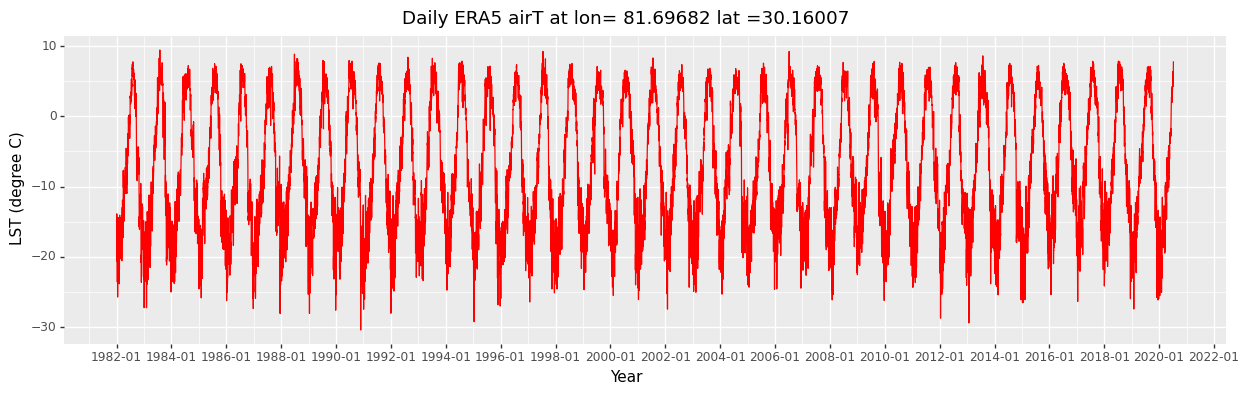

<ggplot: (8756600923501)>


In [14]:
plot_daily_airT=(
    ggplot(df_daily_final)  # What data to use
    + geom_line(aes(x="datetime", y="mean_2m_air_temperature"),colour='red')
    +ylab('LST (degree C)')+xlab('Year')
    + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y-%m'))
    +ggtitle('Daily ERA5 airT at lon= '+str(my_lon)+' lat ='+str(my_lat))
    +theme(figure_size=(15, 4)) #x,y)
)

print(plot_daily_airT)

# Download data to local machine

In [15]:
# load necessary files
from google.colab import files

# define output filename
my_filename="ERA5_daily_"+my_variable+'_lon_'+str(my_lon)+'_lat_'+str(my_lat)+'_'+i_date+'_'+f_date+'.csv'
print('my file name is: ',my_filename)

# Convert dataframe to csv
df_daily_final.to_csv(my_filename, encoding = 'utf-8-sig') 

# download csv
files.download(my_filename)

my file name is:  ERA5_daily_mean_2m_air_temperature_lon_81.69682_lat_30.16007_1982-01-01_2020-12-31.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>